In [1]:
from importlib import reload
from astropy import units as u
from astropy import constants as const
# from astropy.modeling.models import BlackBody
# from astropy.units.equivalencies import spectral

import math

import numpy as np
import matplotlib.pyplot as plt
import pandas
from scipy.interpolate import UnivariateSpline

# from scipy.special import expn
# from scipy.integrate import simpson

from src import astro530
from src import N_integrator

## Partition Function

In [2]:
ion_df = pandas.read_csv("data/ioniz.csv").fillna("-")
ion_df

,Z,Element,MMW,1ion,2ion,3ion
0,1,H,1.008,13.6,-,-
1,2,He,4.003,24.59,54.42,-
2,3,Li,6.941,5.39,75.64,122.45
3,4,Be,9.012,9.32,18.21,153.89
4,5,B,10.811,8.3,25.15,37.93
...,...,...,...,...,...,...
87,88,Ra,226.025,5.28,10.14,34.0
88,89,Ac,227.000,6.9,12.1,20.0
89,90,Th,232.038,6.0,11.5,20.0
90,91,Pa,230.040,-,-,-


In [3]:
rpf_df = pandas.read_csv("data/RepairedPartitionFunctions.csv")#.fillna("-")
rpf_df

,Theta=,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8,2,log_g0
0,H,0.368,0.303,0.301,0.301,0.301,0.301,0.301,0.301,0.301,0.301,0.301
1,He,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0
2,He+,0.301,0.301,0.301,0.301,0.301,0.301,0.301,0.301,0.301,0.301,0.301
3,Li,-,0.987,0.488,0.359,0.320,0.308,0.304,0.302,0.302,0.302,0.301
4,Be,-,0.328,0.087,0.025,0.007,0.002,0.001,0.000,0.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
242,Pa+,2.985,2.413,2.169,1.990,1.846,1.723,1.615,1.515,1.419,1.323,1.519
243,Pa++,-,2.106,1.845,1.652,1.469,1.281,1.088,0.895,0.708,0.532,-
244,U,3.221,2.696,2.298,2.032,1.849,1.719,1.623,1.552,1.498,1.455,1.929
245,U+,2.694,2.031,1.719,1.553,1.455,1.392,1.349,1.317,1.292,1.270,1.716


In [4]:
nion_df = pandas.read_csv("data/nist_ioniz.csv").fillna(0)
nion_df.loc[nion_df.Z==1]["1ion"].values[0]

13.59843401

In [5]:
b = "ScII"
a = list(b)
"".join(a[:-2])+"+"

'Sc+'

In [6]:
def partition(species="H",temp=5000,s_val = 0,k_val = 1):
    
    species_list = list(species)
    if len(species_list) > 3:
        if species_list[-1] == "I" and species_list[-2] == "I" and species_list[-3] == "I":
            species = "".join(species[:-3]+"++")
        elif species_list[-1] == "I" and species_list[-2] == "I":
            species = "".join(species[:-2]+"+")
        elif species_list[-1] == "I":
            species = "".join(species[:-1])
            
    elif len(species_list) > 2:
        if species_list[-1] == "I" and species_list[-2] == "I":
            species = "".join(species[:-2]+"+")
        elif species_list[-1] == "I":
            species = "".join(species[:-1])
            
    elif len(species_list) > 1:
        if species_list[-1] == "I":
            species = "".join(species[:-1])
    
    if species == "H+": species = "He"
    try:
        data = rpf_df.loc[rpf_df["Theta="]==species].to_numpy()[0][1:-1]
    except:
        raise ValueError(species+" is not a valid species.")
    
    log_g0 = rpf_df.loc[rpf_df["Theta="]==species].log_g0.values[0]
    
    th = 5040/temp
    
    theta = []
    temp_data = []
    
    for i,d in enumerate(data):
        if d != "-":
            temp_data.append(float(d))
            theta.append(0.2*(i+1))
            
    if log_g0 != "-":
        temp_data.append(log_g0)
        theta.append(5)
        
    data = np.array(temp_data)
    theta = np.array(theta)
    
    p_US = UnivariateSpline(theta,data,s=0,k=k_val)
    if k_val != 1:
        temp = np.linspace(0,2,50)
        p_US = UnivariateSpline(temp, p_US(temp),s=0,k=1)
    return(10**p_US(th))

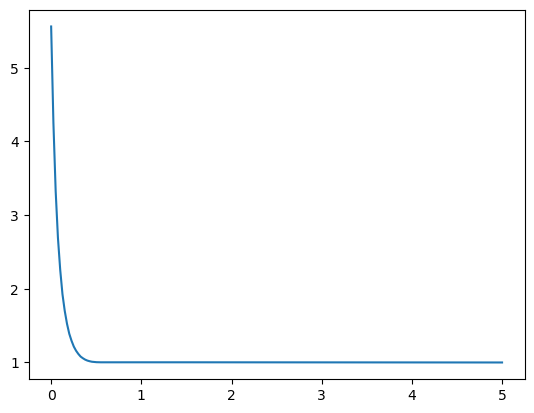

In [7]:
temp_arr  = np.linspace(1e-10,5,200)
p_arr = partition(species="CIII",temp = 5040/temp_arr,k_val=5)

plt.plot(temp_arr,p_arr)

In [8]:
species = "H"
T=5000
theta = []
data = rpf_df.loc[rpf_df["Theta="]==species].to_numpy()[0][1:-1]
temp_data = []

for i,d in enumerate(data):
    if d != "-":
        temp_data.append(float(d))
        theta.append(0.2*(i+1))
data = np.array(temp_data)
theta = np.array(theta)
th = 5040/T
p_US = UnivariateSpline(theta,data,s=0,k=1)

print(10**p_US(th))

1.9998618696327441


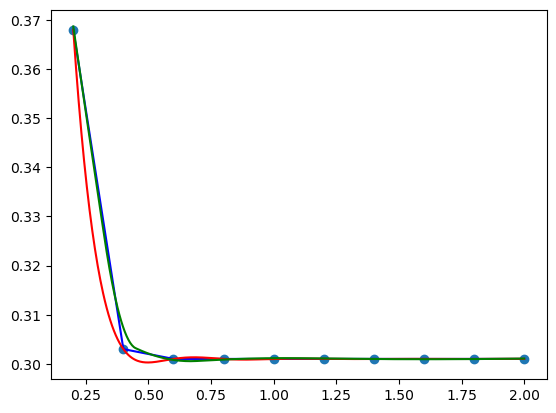

In [10]:
us = UnivariateSpline(theta,data,s=0,k=1)
us1 = UnivariateSpline(theta,data,s=0,k=5)
us2 = UnivariateSpline(np.linspace(0.2,2,30),us(np.linspace(0.2,2,30)),s=1e-5,k=2)
T_sim = np.linspace(0.2,2,500)
plt.plot(T_sim,us(T_sim),c='b')
plt.plot(T_sim,us1(T_sim),c='r')
plt.plot(T_sim,us2(T_sim),c='g')
plt.scatter(theta,data)

## data